In [1]:
import time

import platform
import io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

train_dataset = MNIST(root='../data', 
                      train=True, 
                      transform=transforms.ToTensor(),  
                      download=True)

test_dataset = MNIST(root='../data', 
                     train=False, 
                     transform=transforms.ToTensor())

use_gpu = torch.cuda.is_available()

print("GPU Available: {}".format(use_gpu))


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!
GPU Available: True


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
use_gpu #this will be true if runtime type is set to gpu

True

In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [8]:
image, label = train_dataset[0]

In [9]:
label

5

Label:  5


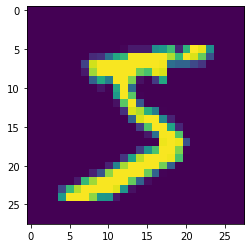

In [13]:
_ = plt.imshow(image.squeeze()) # or reshape
print("Label: ", label)

In [19]:
def prediction(loader, model):
  '''
  inputs: 
  outputs: 
  '''
  correct = 0
  total = 0
  losses = 0

  for i, (images, labels) in enumerate(loader):
    if use_gpu:
      # switch tensor type to GPU
      images = images.cuda()
      labels = labels.cuda()
    
      # Flatten the images
    
    images = images.view(-1, 28*28)
    
    outputs = model(images)
    
    loss = criterion(outputs, labels)
  
    _, predictions = torch.max(outputs, 1)
  
    correct += torch.sum(labels == predictions).item()
    total += labels.shape[0]
    
    losses += loss.data.item()
    
  return losses/len(list(loader)), 1 - correct/total # we need to normalize loss with respect to the number of batches 


def L2_weights_norm(model):
    weights = []
    L2_norm = 0
    for name, parameter in model.named_parameters():
        if 'weight' in name: 
            weights.append(parameter)
            
    for w in weights:
      L2_norm += torch.norm(w)**2

    return L2_norm.item()
  


In [14]:
batch_size = 100 # hyper parameter

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [15]:
len(train_loader)

600

In [16]:
# # It's important to appreciate the data format, e.g. dimensions, type, etc. 

dd = list(train_loader)

In [17]:
images, labels = dd[0] # the first batch

In [18]:
images.shape

torch.Size([100, 1, 28, 28])

torch.Size([28, 28])
Target: 0


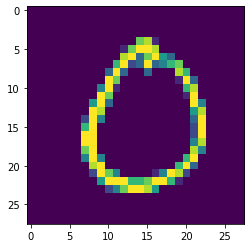

In [20]:
images = dd[0][0]
labels = dd[0][1]


image = images[0]
label = labels[0]

print(image.squeeze().shape) # this makes the shape of image [28, 28] instead of [1, 28, 28]


print('Target: {}'.format(label))
plt.imshow(image.squeeze())
plt.show()

# see import matplotlib.pyplot as plt


# Extract from dd an image and its label
#...

In [21]:
# output = L3(L2(L1(input)))
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
      super(MLP, self).__init__()

      h1, h2 = hidden_sizes

      self.block1 = nn.Sequential(
            nn.Linear(input_size, h1),
            nn.Linear(h1, h2),
            nn.Linear(h2, num_classes)
      )
    
    def forward(self, x):
      out = self.block1(x)

      return out

In [ ]:
input_size = 784
hidden_size = [1000, 1000]
num_classes = 10

MLP_model = MLP(input_size, hidden_size, num_classes)
MLP_model_r = MLP(input_size, hidden_size, num_classes)

if use_gpu:
  # switch model to GPU
  MLP_model.cuda()
  MLP_model_r.cuda()

In [ ]:
learning_rate = 1e-3

criterion = nn.CrossEntropyLoss()  

optimizer = torch.optim.SGD(MLP_model.parameters(), lr=learning_rate)
optimizer_r = torch.optim.SGD(MLP_model_r.parameters(), lr=learning_rate, weight_decay=0.01)

In [ ]:
# lists to plot: 

train_losses = []
train_losses_r = []
    
test_losses = []
test_losses_r = []

train_error_rates = []
train_error_rates_r = []
    
test_error_rates = []
test_error_rates_r = []

L2_Norms = []
L2_Norms_r = []

t0 = time.time()

num_epochs = 10
for epoch in range(num_epochs):
    
    loss = 0
    loss_r = 0
    n_iter = 0
    
    # Iterate over data.
    for i, (images, labels) in enumerate(train_loader):  
        # Zero the gradient buffer
        optimizer.zero_grad()  

        optimizer_r.zero_grad()          
        
        if use_gpu:
          # switch tensor type to GPU
          images = images.cuda()
          labels = labels.cuda()
        
        # Flatten the images
        images = images.view(-1, 28*28)
        
        # Forward
        outputs = MLP_model(images)
        outputs_r = MLP_model_r(images)        
        
        loss_bs = criterion(outputs, labels)
        loss_bs_r = criterion(outputs_r, labels)        
        
        # Backward
        loss_bs.backward()
        loss_bs_r.backward()        
        
        # Optimize
        optimizer.step()
        optimizer_r.step()        
        
        # Statistics
        loss += loss_bs.data.item()
        loss_r += loss_bs_r.data.item()        
        
        n_iter += 1
        
    if epoch%1 == 0:
      print('Epoch: {}/{}, Loss: {:.4f}, Loss_r: {:.4f}'.format(
          epoch+1, num_epochs, loss/n_iter, loss_r/n_iter))
    
    ## compute stuff we need to plot 

    train_loss, train_error_rate = prediction(train_loader, MLP_model) 
    train_loss_r, train_error_rate_r = prediction(train_loader, MLP_model_r) 

    test_loss, test_error_rate = prediction(test_loader, MLP_model) 
    test_loss_r, test_error_rate_r = prediction(test_loader, MLP_model_r) 
    
    ## store the 'stuff' we need to plot in lists. Those are defined above. 
    
    L2_Norms.append(L2_weights_norm(MLP_model))
    L2_Norms_r.append(L2_weights_norm(MLP_model_r))
    
    train_losses.append(train_loss)
    train_losses_r.append(train_loss_r)        
    
    test_losses.append(test_loss)
    test_losses_r.append(test_loss_r)    

    train_error_rates.append(train_error_rate)
    train_error_rates_r.append(train_error_rate_r)
    
    test_error_rates.append(test_error_rate)
    test_error_rates_r.append(test_error_rate_r)

tf = time.time()    
print()
print('Time : {} s'.format(tf-t0))

Epoch: 1/10, Loss: 0.7439, Loss_r: 0.7872
Epoch: 2/10, Loss: 0.6772, Loss_r: 0.7190
Epoch: 3/10, Loss: 0.6266, Loss_r: 0.6672
Epoch: 4/10, Loss: 0.5870, Loss_r: 0.6267
Epoch: 5/10, Loss: 0.5552, Loss_r: 0.5942
Epoch: 6/10, Loss: 0.5291, Loss_r: 0.5676
Epoch: 7/10, Loss: 0.5074, Loss_r: 0.5455
Epoch: 8/10, Loss: 0.4890, Loss_r: 0.5268
Epoch: 9/10, Loss: 0.4733, Loss_r: 0.5108
Epoch: 10/10, Loss: 0.4597, Loss_r: 0.4970

Time : 202.83661651611328 s


In [ ]:
100*test_error_rates[-1]

In [ ]:
fig, (ax1) = plt.subplots(1,figsize=(7,6))

ax1.plot([60],[-1],'o',markersize=8,color=[0.8,0.8,0.8])
ax1.plot([60],[-1],'o',markersize=8,color=[0.8,0.8,0.8],markerfacecolor = 'w')

ax1.plot(train_error_rates,'-ko',markersize=6)
ax1.plot(test_error_rates,'-ro',markersize=6)

ax1.plot(train_error_rates_r,'-ko',markersize=6, markerfacecolor = 'w')
ax1.plot(test_error_rates_r,'-ro',markersize=6, markerfacecolor = 'w')

ax1.set_ylabel('Error rate (%)',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)

ax1.set_ylim([0,0.4])
for i, ax in enumerate([ax1]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
ax1.text(0.8*(xmax - xmin) + xmin, 0.75*(ymax-ymin) + ymin,'Train', fontsize=16,color='k')        
ax1.text(0.8*(xmax - xmin) + xmin, 0.68*(ymax-ymin) + ymin,'Valid', fontsize=16,color='r')        

legend = ax1.legend(['No regularization','Regularization'],loc='upper right',fontsize=14,frameon=False)
plt.suptitle('Effect of the weight decay', fontsize=20, y=1.05)
plt.tight_layout()

plt.show()        

# fig.savefig('Figures/Q1/Q1_weight_decay_no_regularization.pdf') #, bbox_inches='tight'


In [ ]:
fig, (ax) = plt.subplots(1,figsize=(7,6))

ax.plot(L2_Norms,'-ob',markersize=8)
ax.plot(L2_Norms_r,'-ob',markersize=8, markerfacecolor='w')

####################################################################################
####################################################################################

ax.set_ylabel('L2 norm',fontsize=14)
ax.set_xlabel('Epoch',fontsize=14)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
# ax.text(0.7*(xmax - xmin) + xmin, 0.8*(ymax-ymin) + ymin,'$\lambda = 2.5$', fontsize=16 ,color='k')        

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)        

legend = ax.legend(['No regularization','Regularization'],loc='center right',fontsize=14,frameon=False)

plt.show()        
    
# fig.savefig('Figures/Q1/Q1_L2Norm.pdf')
